# Install Dependencies

In [1]:
# !pip install torch_summary

# Import Libraries

In [2]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm.notebook import tqdm 

from sklearn.metrics import classification_report, recall_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle, randint, choice
import numpy as np
import cv2 as cv
from glob import glob
import pandas as pd
import os

In [3]:
# !mkdir saved_model
sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
with torch.no_grad():
    torch.cuda.empty_cache()

# Dataset

In [4]:
G1020 = 'G1020'

G1020_df = pd.read_csv(f'{G1020}/G1020.csv', index_col=0).reset_index()

G1020_df.head()

,imageID,binaryLabels
0,image_0.jpg,0
1,image_1.jpg,0
2,image_3.jpg,0
3,image_4.jpg,0
4,image_5.jpg,0


In [5]:
#G1020_df['filepath'] = G1020_df['imageID'].apply(lambda x: 'G1020/Images/' + x)
G1020_df['filepath'] = G1020_df['imageID'].apply(lambda x: 'Augmented Images/' + x)

G1020_df.head()

,imageID,binaryLabels,filepath
0,image_0.jpg,0,Augmented Images/image_0.jpg
1,image_1.jpg,0,Augmented Images/image_1.jpg
2,image_3.jpg,0,Augmented Images/image_3.jpg
3,image_4.jpg,0,Augmented Images/image_4.jpg
4,image_5.jpg,0,Augmented Images/image_5.jpg


In [6]:
ORIGA = 'ORIGA'

ORIGA_df = pd.read_csv(f'{ORIGA}/origa_info.csv', index_col=0).reset_index()

ORIGA_df.head()

,Image,Source,Cropped,CDR,Ecc-Cup,Ecc-Disc,Label
0,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7097,0.636027,0.580909,0
1,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6953,0.575024,0.608413,0
2,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.9629,0.299303,0.262828,0
3,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7246,0.503186,0.483273,0
4,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6138,0.500141,0.283467,0


In [7]:
#ORIGA_df['filepath'] = ORIGA_df['Image'].apply(lambda x: 'ORIGA/Images/' + x.split('/')[-1])
ORIGA_df['filepath'] = ORIGA_df['Image'].apply(lambda x: 'Augmented Images/' + x.split('/')[-1])

ORIGA_df.head()

,Image,Source,Cropped,CDR,Ecc-Cup,Ecc-Disc,Label,filepath
0,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7097,0.636027,0.580909,0,Augmented Images/001.jpg
1,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6953,0.575024,0.608413,0,Augmented Images/002.jpg
2,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.9629,0.299303,0.262828,0,Augmented Images/003.jpg
3,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7246,0.503186,0.483273,0,Augmented Images/004.jpg
4,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6138,0.500141,0.283467,0,Augmented Images/005.jpg


In [8]:
REFUGE_df_train = pd.read_json('REFUGE/train/index.json')
REFUGE_df_train = REFUGE_df_train.T


REFUGE_df_train['filepath'] = REFUGE_df_train['ImgName'].apply(lambda x: 'Augmented Images/' + x)

# print(REFUGE_df_train.head())
# print(REFUGE_df_train.shape)

REFUGE_df_val = pd.read_json('REFUGE/val/index.json')
REFUGE_df_val = REFUGE_df_val.T

REFUGE_df_val['filepath'] = REFUGE_df_val['ImgName'].apply(lambda x: 'Augmented Images/' + x)
# print(REFUGE_df_val.head())
# print(REFUGE_df_val.shape)

REFUGE_df = pd.concat([REFUGE_df_train, REFUGE_df_val], ignore_index=True)
print(REFUGE_df.head())
print(REFUGE_df.shape)

     ImgName  Fovea_X  Fovea_Y Size_X Size_Y Label                    filepath
0  g0001.jpg  1057.95  1076.52   2124   2056     1  Augmented Images/g0001.jpg
1  g0002.jpg  1190.59  1017.09   2124   2056     1  Augmented Images/g0002.jpg
2  g0003.jpg  1070.56  1084.85   2124   2056     1  Augmented Images/g0003.jpg
3  g0004.jpg   1072.6  1035.48   2124   2056     1  Augmented Images/g0004.jpg
4  g0005.jpg  1058.19  1100.33   2124   2056     1  Augmented Images/g0005.jpg
(800, 7)


In [9]:
full_df = pd.DataFrame()
full_df['filepath'] = G1020_df['filepath'].tolist() + ORIGA_df['filepath'].tolist() + REFUGE_df['filepath'].tolist()
full_df['label'] = G1020_df['binaryLabels'].tolist() + ORIGA_df['Label'].tolist() + REFUGE_df['Label'].tolist()
full_df.sample(frac=1)
print(full_df.head())
print(full_df.shape)

print(full_df['label'].value_counts())

                       filepath  label
0  Augmented Images/image_0.jpg      0
1  Augmented Images/image_1.jpg      0
2  Augmented Images/image_3.jpg      0
3  Augmented Images/image_4.jpg      0
4  Augmented Images/image_5.jpg      0
(2470, 2)
label
0    1926
1     544
Name: count, dtype: int64


In [10]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# # 0
# imgpath = full_df[full_df['label']==0].sample(1)['filepath'].values[0]
# img = Image.open(f'{imgpath}')
# ax[0].imshow(img)
# ax[0].set_title('Sample 0')
# ax[0].axis('off')

# # 1
# imgpath = full_df[full_df['label']==1].sample(1)['filepath'].values[0]
# img = Image.open(f'{imgpath}')
# ax[1].imshow(img)
# ax[1].set_title('Sample 1')
# ax[1].axis('off')

# Split Dataset

In [11]:
label0_df = full_df[full_df['label'] == 0]
label1_df = full_df[full_df['label'] == 1]

label0_train, label0_valid = train_test_split(label0_df, test_size=0.2, random_state=42)
label1_train, label1_valid = train_test_split(label1_df, test_size=0.2, random_state=42)

train_df = pd.concat([label0_train, label1_train]).sample(frac=1, random_state=42)
valid_df = pd.concat([label0_valid, label1_valid]).sample(frac=1, random_state=42)

print(train_df['label'].value_counts())
print(valid_df['label'].value_counts())

label
0    1540
1     435
Name: count, dtype: int64
label
0    386
1    109
Name: count, dtype: int64


# Data Augmentation on Train Set Class 1 Entries

In [12]:
class_0_train_df = train_df[train_df['label'] == 0]
class_1_train_df = train_df[train_df['label'] == 1]

class_1_train_df.head()
print(class_1_train_df.shape)

temp_class_1_train_df = pd.DataFrame()

for row in class_1_train_df.iterrows():
    image_name = row[1]['filepath'][17:-4]
    dict = {'filepath':[], 'label':[] }

    for i in range(2, 4):
        new_img_name = 'Augmented Images/' + image_name + '_aug_' + str(i) + '.jpg'
        dict['filepath'].append(new_img_name)
        dict['label'].append(1)

    temp_df = pd.DataFrame(dict)
    temp_class_1_train_df = pd.concat([temp_class_1_train_df, temp_df], ignore_index = True)

class_1_train_df = pd.concat([class_1_train_df, temp_class_1_train_df], ignore_index = True)
print(class_1_train_df.shape)

train_df = pd.concat([class_0_train_df, class_1_train_df], ignore_index=True)
print(train_df.head())
print(train_df.shape)


    

(435, 2)
(1305, 2)
                          filepath  label
0       Augmented Images/n0108.jpg      0
1  Augmented Images/image_1260.jpg      0
2       Augmented Images/V0386.jpg      0
3         Augmented Images/099.jpg      0
4         Augmented Images/309.jpg      0
(2845, 2)


In [13]:
print(train_df.shape)
print(train_df['label'].value_counts())
print(valid_df)
print(valid_df['label'].value_counts())

(2845, 2)
label
0    1540
1    1305
Name: count, dtype: int64
                             filepath  label
801   Augmented Images/image_2564.jpg      1
1434         Augmented Images/415.jpg      0
2433       Augmented Images/V0364.jpg      0
1208         Augmented Images/189.jpg      0
1630         Augmented Images/611.jpg      0
...                               ...    ...
808   Augmented Images/image_2572.jpg      0
842   Augmented Images/image_2688.jpg      0
1447         Augmented Images/428.jpg      0
1178         Augmented Images/159.jpg      1
2262       Augmented Images/V0193.jpg      0

[495 rows x 2 columns]
label
0    386
1    109
Name: count, dtype: int64


In [14]:
for row in train_df.iterrows():
    image_name = row[1]['filepath']
    image_label = row[1]['label']
    filepath = image_name

    exists = os.path.exists(filepath)
    if not exists:
        print(image_name)
        print(os.path.exists(filepath))
    if image_label not in [0, 1]:
        print(image_label)

# Prepare Dataset and Dataloader

In [15]:
class EyeDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.transform = T.Compose([
            T.Resize([224, 224]),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406),
                       (0.229, 0.224, 0.225))
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        filepath = f"{self.df.iloc[idx]['filepath']}"
#         image = Image.open(filepath)
        image = cv.imread(filepath)
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        image = cv.cvtColor(image, cv.COLOR_GRAY2RGB)
        image = Image.fromarray(image)
        target = self.df.iloc[idx]['label']
        
        return image, target
    
    def transform_img(self, img):
        return self.transform(img)
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        targets = torch.tensor(targets)
        targets = targets.view(-1, 1).float()
        targets = targets.to(device)
        imgs = torch.stack(
            [self.transform_img(img) for img in imgs], 0
        ).to(device)
        return imgs, targets

In [16]:
train_ds = EyeDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,
                      collate_fn=train_ds.collate_fn, 
                      drop_last=True)

valid_ds = EyeDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=64,
                      collate_fn=valid_ds.collate_fn)

In [17]:
print('Size of Train:', len(train_ds))
print('Size of Validation:', len(valid_ds))

Size of Train: 2845
Size of Validation: 495


# Model

In [18]:
class EyeClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = models.resnet50(pretrained=pretrained, progress=pretrained)
        for param in self.model.parameters():
            param.requires_grad = True
        
        num_features = self.model.fc.in_features

        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.65),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [19]:
classifier = EyeClassifier(pretrained=True)
_ = summary(classifier, torch.ones(1,3,224,224))

c:\Users\Josiah Foo\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Josiah Foo\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28] 

# Define Train and Validate Functions

In [20]:
def train(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    fake_recall_score = recall_score(targets, preds, 
                               pos_label=0,
                               zero_division=0)
    
    return loss.cpu().detach().item(), fake_recall_score

In [21]:
@torch.no_grad()
def validate(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    fake_recall_score = recall_score(targets, preds, 
                               pos_label=0,
                               zero_division=0)
    
    return loss.cpu().detach().item(), fake_recall_score

In [22]:
classifier = EyeClassifier(pretrained=True).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2,
                                      gamma=0.25)
best_recall_score = 0
# lowest_loss_score = float('inf')
n_epochs = 10
xticks = list(i+1 for i in range(n_epochs))

In [23]:
mem = {
    'train_loss': [],
    'train_recall_score': [],
    'valid_loss': [],
    'valid_recall_score': []
}

print('Starting Training')
for epoch in tqdm(range(n_epochs), desc='Training'):
    n_batch = len(train_dl)
    train_losses, train_recall_scores = [], []
    for i, data in enumerate(train_dl):
        train_loss, train_recall_score = train(data, classifier,
                                         optimizer, loss_fn)
        train_losses.append(train_loss)
        train_recall_scores.append(train_recall_score)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\ttrain loss:', "%.3f" % train_loss,
            '\ttrain recall score:', "%.3f" % train_recall_score, 
            end='\r'
        )
        
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_recall_score'].append(np.mean(train_recall_scores))
    
    n_batch = len(valid_dl)
    valid_losses, valid_recall_scores = [], []
    for i, data in enumerate(valid_dl):
        valid_loss, valid_recall_score = validate(data, classifier, loss_fn)
        valid_losses.append(valid_loss)
        valid_recall_scores.append(valid_recall_score)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\tvalid loss:', "%.3f" % valid_loss,
            '\tvalid recall score:', "%.3f" % valid_recall_score, 
            end='\r'
        )
    
    cur_recall_score = np.mean(valid_recall_scores)
    mem['valid_loss'].append(np.mean(valid_losses))
    mem['valid_recall_score'].append(cur_recall_score)
    
    print(
        'epoch:', epoch+1,
        '\ttrain loss:', "%.3f" % mem['train_loss'][-1],
        '\ttrain recall score:', "%.3f" % mem['train_recall_score'][-1],
        '\tvalid loss:', "%.3f" % mem['valid_loss'][-1],
        '\tvalid recall score:', "%.3f" % mem['valid_recall_score'][-1],
    )
    
    if best_recall_score < cur_recall_score:
        best_recall_score = cur_recall_score
        torch.save(classifier.state_dict(), 'glaucoma_state_dict.pth')
        torch.save(classifier, 'glaucoma_model.pth')
    
    # cur_loss_score = np.mean(valid_losses)
    # if cur_loss_score < lowest_loss_score:
    #     lowest_loss_score = cur_loss_score
    #     torch.save(classifier.state_dict(), 'glaucoma_state_dict.pth')
    #     torch.save(classifier, 'glaucoma_model.pth')
        
    scheduler.step()

Starting Training


Training:   0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 	train loss: 0.606 	train recall score: 0.840 	valid loss: 0.736 	valid recall score: 0.597
epoch: 2 	train loss: 0.373 	train recall score: 0.922 	valid loss: 0.612 	valid recall score: 0.814
epoch: 3 	train loss: 0.335 	train recall score: 0.960 	valid loss: 0.444 	valid recall score: 0.983
epoch: 4 	train loss: 0.297 	train recall score: 0.973 	valid loss: 0.450 	valid recall score: 0.952
epoch: 5 	train loss: 0.280 	train recall score: 0.951 	valid loss: 0.452 	valid recall score: 0.963
epoch: 6 	train loss: 0.272 	train recall score: 0.962 	valid loss: 0.470 	valid recall score: 0.938
epoch: 7 	train loss: 0.263 	train recall score: 0.950 	valid loss: 0.464 	valid recall score: 0.943
epoch: 8 	train loss: 0.258 	train recall score: 0.961 	valid loss: 0.465 	valid recall score: 0.943
epoch: 9 	train loss: 0.258 	train recall score: 0.955 	valid loss: 0.471 	valid recall score: 0.937
epoch: 10 	train loss: 0.255 	train recall score: 0.952 	valid loss: 0.466 	valid recall sc

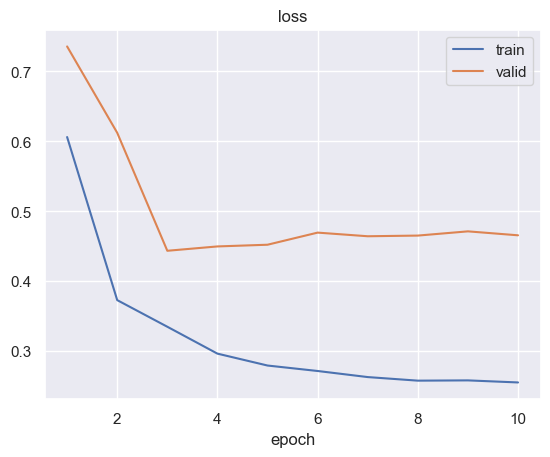

In [24]:
plt.plot(xticks, mem['train_loss'])
plt.plot(xticks, mem['valid_loss'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('loss')
plt.show()

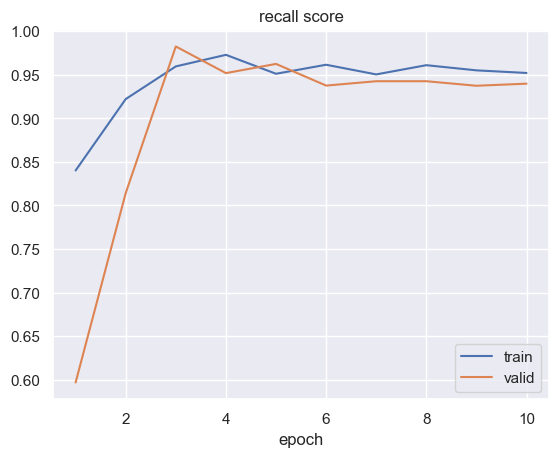

[0.5967156851201018, 0.8142067262378061, 0.9825620631710054, 0.951937069604422, 0.962517698132429, 0.9376214914639852, 0.942629504284498, 0.942629504284498, 0.9374211709511646, 0.9398250171050109]


In [25]:
plt.plot(xticks, mem['train_recall_score'])
plt.plot(xticks, mem['valid_recall_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('recall score')
plt.show()
print(mem['valid_recall_score'])